In [1]:
### INITIALISATION ###

import numpy as np          # fundamental package for scientific computing
import xarray as xr         # data handling
import glob                 # return all file paths that match a specific pattern
import os                   # provide operating system-related functions
import pop_tools            # to mask region of interest
import gsw                  # compute potential density

path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel/'
salt_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt/'
temp_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/'
files = sorted(glob.glob(path + '*.nc'))

# setting up of regional mask
grid_name = 'POP_gx1v7'
#setting up of regional mask
region_defs = {
    'North Atlantic and Nordic Seas': [{'match': {'REGION_MASK': [6, 7]},#, 9]}, 
                             'bounds': {'TLAT': [20., 59.]}}],
    'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 59.]}}]
} 
mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic and Nordic Seas')
mask3d = mask3d.sum('region')

# target sigam levels
sigma_level = [12. , 16. , 20. , 24. , 28. , 28.5 , 29.2 , 29.4 , 29.6 , 29.8 , 30. , 30.2 , 30.4 , 30.6 , 
                       30.8 , 31. , 31.2 , 31.4 , 31.6 , 31.8 , 32. , 32.2 , 32.4 , 32.6 , 32.8 , 33. , 33.2 , 33.4 , 
                       33.6 , 33.8 , 34. , 34.2 , 34.4 , 34.6 , 34.8 , 35. , 35.2 , 35.4 , 35.6 , 35.8 , 36.1 , 36.2 , 
                       36.3 , 36.4 , 36.55, 36.6 , 36.65, 36.7 , 36.72, 36.74, 36.76, 36.78, 36.8 , 36.82, 36.84, 
                       36.86, 36.88, 36.9 , 36.92, 36.94, 36.96, 36.98, 37. , 37.02, 37.04, 37.06, 37.08, 37.1 , 
                       37.12, 37.14, 37.16, 37.18, 37.2 , 37.25, 37.3 , 37.35, 37.4 , 37.45, 37.6 , 37.7 , 37.8 , 
                       37.9 , 38. , 39. , 40. , 41. , 42.]

print('initialisation complete')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


initialisation complete


# Plot location of metrics

In [2]:
import matplotlib.pyplot as plt
ds_plot = xr.open_dataset(files[0]).isel(time=slice(0,20)).mean('time').where(mask3d == 1).roll(nlon=-100)

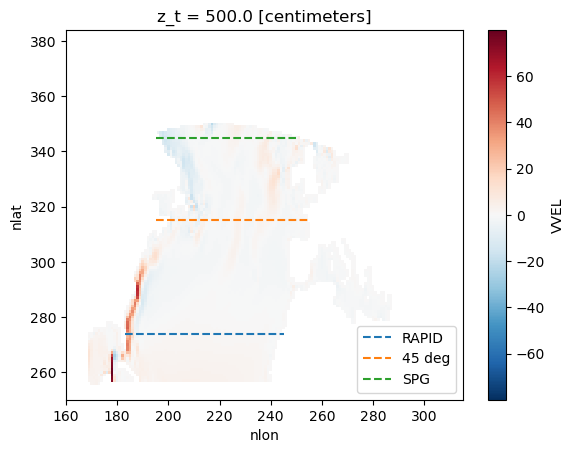

In [3]:

ds_plot.VVEL.isel(z_t=0).plot()

plt.plot([183,245],[274, 274], linestyle='--', label='RAPID')
plt.plot([195,255],[315, 315], linestyle='--', label='45 deg')
plt.plot([195,250],[345, 345], linestyle='--', label='SPG')
#plt.plot([270,270],[348, 382], linestyle='--', label='Nordic Seas')

plt.xlim([160, 315])
plt.ylim([250, 384])

plt.legend(loc='lower right')

plt.show()

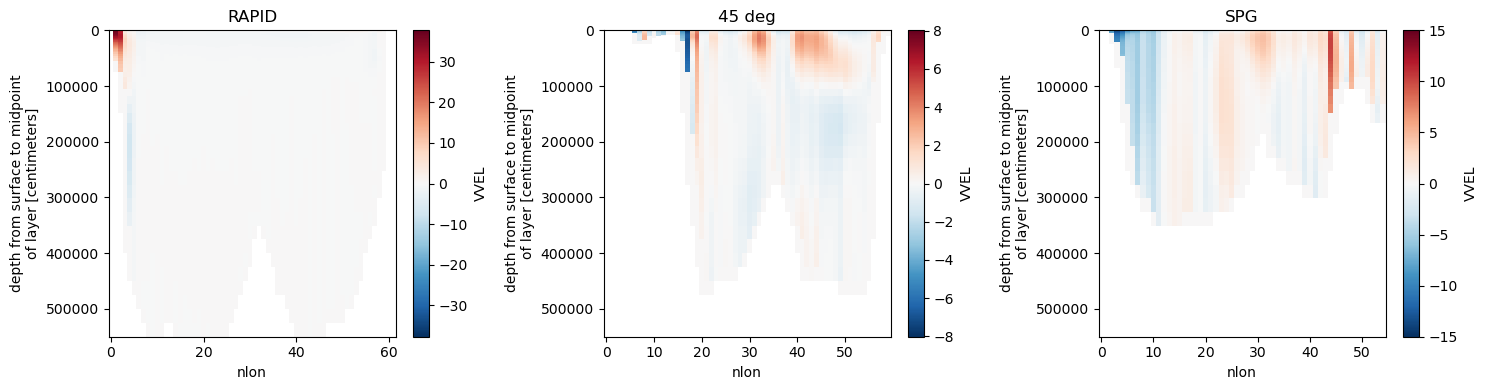

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot for ds_plot1
ds_plot.VVEL.isel(nlat=271, nlon=slice(183, 245)).plot(ax=axes[0], yincrease=False)
axes[0].set_title('RAPID')

# Plot for ds_plot2
ds_plot.VVEL.isel(nlat=315, nlon=slice(195, 255)).plot(ax=axes[1], yincrease=False)
axes[1].set_title('45 deg')

# Plot for ds_plot3
ds_plot.VVEL.isel(nlat=345, nlon=slice(195, 250)).plot(ax=axes[2], yincrease=False)
axes[2].set_title('SPG')

plt.tight_layout()
plt.show()

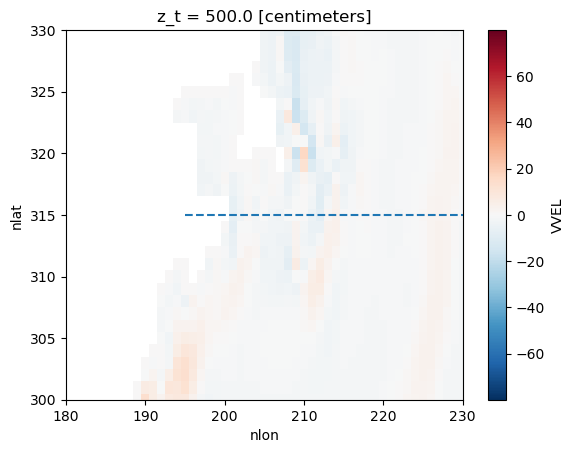

In [5]:
ds_plot.VVEL.isel(z_t=0).plot()
plt.plot([195,255],[315, 315], linestyle='--', label='45 deg')
plt.xlim([180, 230])
plt.ylim([300, 330])
plt.show()

# Compute metrics

In [6]:
def density_MOC(ds):

    # define range on pop-grid
    min_lat=250
    max_lat=360
    
    overturning = np.zeros([len(sigma_level), (max_lat-min_lat)])

    for j in range(min_lat,max_lat):
        # prepare transport array
        sigma_transport = np.zeros(len(sigma_level))

        ### compute velocity transport
        v_transport = (ds.VVEL.isel(nlat=j) * ds.dz.isel(nlat=j) * ds.DXU.isel(nlat=j)).values

        ### get sigma vlaues for selected cross section
        sigma_crossection = ds.SIGMA.isel(nlat=j).values

        ### sum over longitudes per sigma bin
        for i in range(len(sigma_level)-1):
            ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i+1]))
            sigma_transport[i] = np.nansum(v_transport[ind])

        ## compute overturning
        overturning[:,j-min_lat] = np.cumsum(sigma_transport)[::-1]
        overturning[:,j-min_lat] = overturning[:,j-min_lat][::-1]
        
    # find maximumat RAPID time step
    rapi = np.max(overturning[:,274-min_lat])
    # find maximum at 45 degree time step
    fofi = np.max(overturning[:,315-min_lat])
    # find maximum at SPG time step
    spgy = np.max(overturning[:,345-min_lat])
    # find basin wide maximum of time step
    maxi = np.max(overturning)
    # find location of maximum of time step
    max_index = np.argmax(overturning)
    max_loc = np.unravel_index(max_index, overturning.shape)

    return rapi*1e-12, fofi*1e-12, spgy*1e-12, maxi*1e-12, max_loc[1], overturning


In [7]:
### COMPUTATION ###

i =0
t =0

# load files and combine for one time step into one dataset
salt = salt_path + 'salt_' + files[i][-11:]
temp = temp_path + 'temp_' + files[i][-11:]
ds = xr.open_dataset(files[i]).isel(time=t).where(mask3d == 1).roll(nlon=-100)
ds_salt = xr.open_dataset(salt).isel(time=t).where(mask3d == 1).roll(nlon=-100)
ds_temp = xr.open_dataset(temp).isel(time=t).where(mask3d == 1).roll(nlon=-100)
ds.update(ds_salt[["SALT"]])
ds.update(ds_temp[["TEMP"]])
print('files loaded')

# Conservative Temperature
CT = gsw.conversions.CT_from_pt(ds.SALT, ds.TEMP)
# Potential density
ds['SIGMA'] = gsw.density.sigma2(ds.SALT, CT)
print('potential density computed')
rapi, fofi, spgy, maxi, max_loc, overturning = density_MOC(ds)
print('metrics computed')      

files loaded
potential density computed
metrics computed


In [8]:
print(rapi, fofi, spgy, maxi, max_loc)

17.286009336818008 10.911792911443534 21.972766834299385 25.660703716121564 99


In [9]:
rapi*1e-12

1.728600933681801e-11

# Plot figure

In [10]:
ticks_axdensvol = np.array([30, 35, 36.1, 36.4, 36.6, 36.8, 36.9, 37, 37.06, 37.1, 37.3])
DBb = sigma_level

In [11]:
#yVAR = xr.open_dataset(pfname_axdensvol, decode_times=False)['ticks'].values
# round DBb to 2 orders of magnitude precision to make sure that values match with ticks_axdensvol
#DBb_rd = DBb.round(decimals=2)
# get ticks of volumes corresponding to ticks_axdensvol defined above
#ticks_axdensvol_exact = yVAR[np.in1d(DBb_rd, ticks_axdensvol)]

In [12]:
x = np.arange(0, overturning.shape[1])
y = np.arange(0, overturning.shape[0])
#X, Y = np.meshgrid(x, sigma_level)
X, Y = np.meshgrid(x, y)

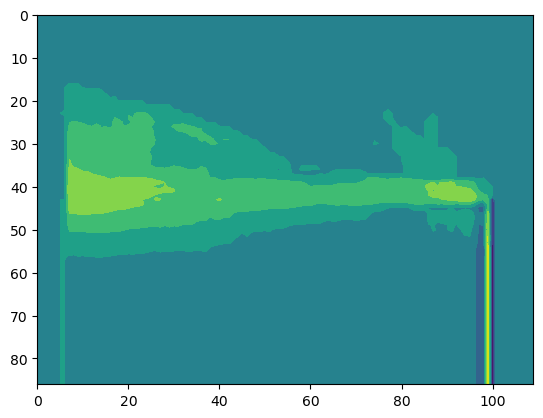

In [13]:
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, overturning)
ax.invert_yaxis()
#ax.set_yscale('log')
plt.show()

In [14]:
overturning.shape

(87, 110)

In [15]:
ticks_axdensvol = np.array([30, 35, 36.1, 36.4, 36.6, 36.8, 36.9, 37, 37.06, 37.1, 37.3, 42.1])

# Double the size of the array
rescaled_size = 5 * (len(ticks_axdensvol))
new_indices = np.linspace(0, len(ticks_axdensvol), rescaled_size)
rescaled_sigma= np.interp(new_indices, np.arange(len(ticks_axdensvol)), ticks_axdensvol)

rescaled_overturning = np.zeros((len(rescaled_sigma), 110))

In [16]:
# write rebinning
i=0
result = []
for row, level in zip(overturning, sigma_level):
    if level <= rescaled_sigma[i]:
        result.append(row)
    else:
        bin_array = np.array(result)
        rescaled_overturning[i] = np.mean(bin_array, axis=0)
        result = []
        result.append(row)
        i=i+1
        
x = np.arange(0, rescaled_overturning.shape[1])
y = np.arange(0, rescaled_overturning.shape[0])
#X, Y = np.meshgrid(x, rescaled_sigma)
X, Y = np.meshgrid(x, y)

In [17]:
indices = np.argmin(np.abs(rescaled_sigma[:, None] - ticks_axdensvol), axis=0)
print(indices)

[ 0  5 10 15 20 25 29 35 39 44 49 55]


In [18]:
print(rescaled_overturning.shape)
print(X.shape)
print(y.shape)
print(rescaled_sigma.shape)

(60, 110)
(60, 110)
(60,)
(60,)


<Figure size 1600x700 with 0 Axes>

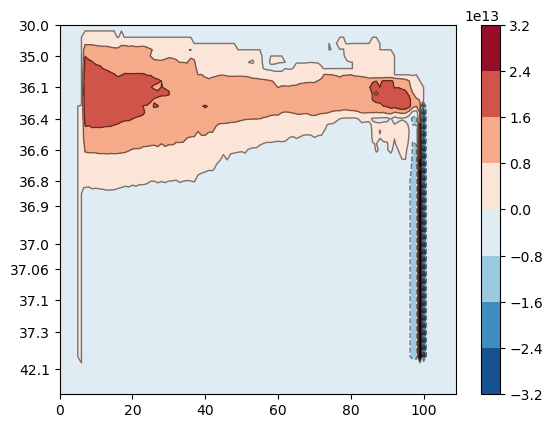

In [19]:
plt.figure(figsize=(16, 7))
fg, ax = plt.subplots(1,1)

pcf = ax.contourf(X, Y, rescaled_overturning, cmap = 'RdBu_r')
plt.gca().invert_yaxis()
    
    
    # plot zero-line
#pc = ax.contour(X, Y, rescaled_overturning, levels=[0], origin='lower', linewidths=2, colors='k')

# plot contour lines
pc = ax.contour(X, Y, rescaled_overturning, origin='lower', linewidths=1, alpha=.5, colors='k')

cb = plt.colorbar(pcf, ax=ax)

plt.yticks(indices)
ax.set_yticklabels(ticks_axdensvol)

plt.show()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
overturning.shape

(87, 110)

In [11]:
overturning

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

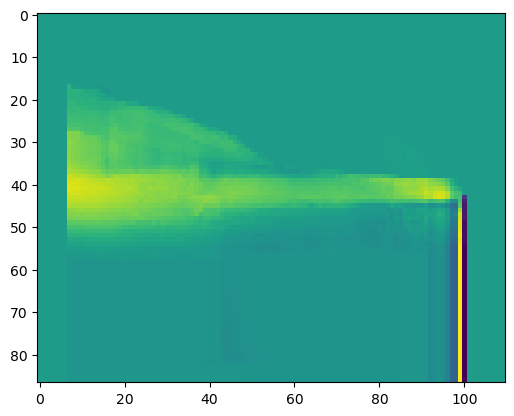

In [12]:
plt.imshow(overturning)